# Subset scenes, DEMs

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shapely
import geopandas as gpd
import rasterio as rio
from rasterio.windows import Window
import rasterio.mask 
import shutil
import glob
from osgeo import gdal
import xarray as xr
from PIL import Image

In [2]:
# set paths
loc = 'frontrange'
track = 'des'

desktop = '/Users/qbren/Desktop'
main_dir = f'{desktop}/taco/projects/atmospheric_correction/data_processing/training_data'
igram_dir = f'{main_dir}/{track}_crop_{loc}_noise'
subsets_dir = f'subsets_{loc}_{track}'
veloc_fn = f'{main_dir}/veloc_crop/{track}_veloc_{loc}.tif'

In [ ]:
def clump_size(array, quantile_threshold=0.99, return_mask=False):
    quantile = np.quantile(np.absolute(array), q=quantile_threshold) # find threshold based on quantile
    mask = np.where(np.absolute(array)>quantile, 1, 0) # get areas above threshold
    s = [[1,1,1],[1,1,1],[1,1,1]] # structure for clumping kernel 
    features, count = ndimage.label(mask, s) # clump features
    feature_ids, feature_counts = np.unique(features, return_counts=True) # count pixels in features
    feature_counts = np.delete(feature_counts, feature_counts.argmax()) # throw away background
    
    if return_mask==True:
        return mask
    
    return feature_counts.mean()
    
# I think the appropriate mean for keeping a subset is 3 pixels per clump with a quantile threshold of 0.99

In [3]:
%%time

# load, crop, and save rasters

# list interferograms
dirs = os.listdir(igram_dir)

# loop through interferograms
for i, idir in enumerate(dirs):
    cwd = f'{igram_dir}/{idir}'
    os.chdir(cwd)
    
    # select the line of sight displacement
    allfiles = os.listdir(cwd)
    for fn in allfiles:
        if fn[-12:] == 'los_disp.tif':
            noise_tif = fn
        elif fn[-7:] == 'dem.tif':
            dem_tif = fn
    noise_tif_fn = f'{igram_dir}/{idir}/{noise_tif}'
    dem_tif_fn =  f'{igram_dir}/{idir}/{dem_tif}'
    xsize, ysize = 125, 125  # define the test image size
    print("working on: ", noise_tif)
    
    subset_number = 50  # define the number of subsets
    subsets = 0
    counter = 0
    
    # loop until subsetting is finished
    while subsets < subset_number:
        counter+=1
        if counter>200 and subsets<1:
            print('too few appropriate subsets')
            break
            
        # open src image
        noise_src = rio.open(noise_tif_fn)
        noise_rs = noise_src.read(1) # also open as np array

        dem_src = rio.open(dem_tif_fn)
        dem_rs = dem_src.read(1) # also open as np array

        veloc_src = rio.open(veloc_fn)
        veloc_rs = veloc_src.read(1) # also open as np array

        # create bounds for new origin location
        xmin, xmax = 0, noise_src.width - xsize
        ymin, ymax = 0, noise_src.height - ysize
        xoff, yoff = np.random.randint(xmin, xmax), np.random.randint(ymin, ymax)

        temp_noise = noise_rs[yoff:(yoff+ysize), xoff:(xoff+xsize)]
        temp_dem = dem_rs[yoff:(yoff+ysize), xoff:(xoff+xsize)]
        temp_veloc = veloc_rs[yoff:(yoff+ysize), xoff:(xoff+xsize)]

        if not 0.0 in temp_noise: # only save if there are no nodata values in subset
            if len(temp_veloc[np.where((temp_veloc<-0.003)|(temp_veloc>0.003))]) > 50: #1% of total subset
                if np.median(temp_dem) >= 3300: # only save if subset is at high elevation
                    window = Window(xoff, yoff, xsize, ysize)
                    noise_transform = noise_src.window_transform(window)
                    dem_transform = dem_src.window_transform(window)
                    veloc_transform = veloc_src.window_transform(window)

                    # write subset
                    noise_profile = noise_src.profile
                    dem_profile = dem_src.profile
                    veloc_profile = veloc_src.profile

                    noise_profile.update({
                        'height': xsize,
                        'width': ysize,
                        'transform': noise_transform})
                    dem_profile.update({
                        'height': xsize,
                        'width': ysize,
                        'transform': dem_transform})
                    veloc_profile.update({
                        'height': xsize,
                        'width': ysize,
                        'transform': veloc_transform})

                    noise_out_fn = f'{desktop}/{subsets_dir}/int/{track}{subsets}_{noise_tif[0:-13]}.tif'
                    dem_out_fn = f'{desktop}/{subsets_dir}/dem/{track}{subsets}_{noise_tif[0:-13]}.tif'
                    veloc_out_fn = f'{desktop}/{subsets_dir}/veloc/{track}{subsets}_{noise_tif[0:-13]}.tif'

                    with rasterio.open(noise_out_fn, 'w', **noise_profile) as noise_dst:
                        # Read the data from the window and write it to the output raster
                        noise_dst.write(noise_src.read(window=window))
                    noise_src.close()

                    with rasterio.open(dem_out_fn, 'w', **dem_profile) as dem_dst:
                        # Read the data from the window and write it to the output raster
                        dem_dst.write(dem_src.read(window=window))
                    dem_src.close()

                    with rasterio.open(veloc_out_fn, 'w', **veloc_profile) as veloc_dst:
                        # Read the data from the window and write it to the output raster
                        veloc_dst.write(veloc_src.read(window=window))
                    veloc_src.close()

                    subsets+=1 # update index

working on:  S1AA_20170502T130927_20170514T130928_VVP012_INT40_G_ueF_54EC_los_disp.tif
working on:  S1AA_20170514T130928_20170526T130928_VVP012_INT40_G_ueF_3D22_los_disp.tif
working on:  S1AA_20170526T130928_20170607T130929_VVP012_INT40_G_ueF_2A5A_los_disp.tif
too few appropriate subsets
working on:  S1AA_20170607T130929_20170619T130930_VVP012_INT40_G_ueF_23F5_los_disp.tif
working on:  S1AA_20170619T130930_20170701T130930_VVP012_INT40_G_ueF_0774_los_disp.tif
working on:  S1AA_20170701T130930_20170713T130931_VVP012_INT40_G_ueF_5F4E_los_disp.tif
working on:  S1AA_20170713T130931_20170725T130932_VVP012_INT40_G_ueF_5F49_los_disp.tif
working on:  S1AA_20170725T130932_20170806T130932_VVP012_INT40_G_ueF_1998_los_disp.tif
working on:  S1AA_20170806T130932_20170818T130933_VVP012_INT40_G_ueF_7736_los_disp.tif
working on:  S1AA_20170818T130933_20170830T130933_VVP012_INT40_G_ueF_42CC_los_disp.tif
working on:  S1AA_20170830T130933_20170911T130934_VVP012_INT40_G_ueF_66BB_los_disp.tif
working on:  S1

## Interpolate gaps if need be

In [4]:
# list subsets 
noise_fns = os.listdir(f'{desktop}/{subsets_dir}/int')

def list_tifs(my_fns):
    my_list = []
    for i in my_fns:
        if i[-4:] == '.tif':
            my_list.append(i)
    return my_list

noise_list = list_tifs(noise_fns)

In [5]:
zeros=[]

for i, fn in enumerate(noise_list):
        noise_fn = f'{desktop}/{subsets_dir}/int/{fn}'

        noise_src = rio.open(noise_fn)
        noise = noise_src.read(1) # also open as np array
        zeros.append(np.count_nonzero(noise==0))

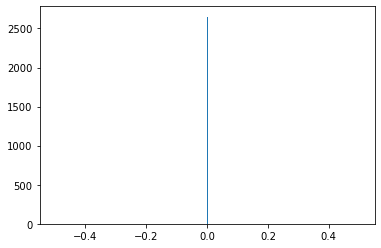

In [6]:
plt.hist(zeros, bins=300);

In [7]:
# interpolate holes
#for i, fn in enumerate(noise_list):
#        noise_fn = f'{desktop}/{subsets_dir}/int/{fn}'
#
#        noise_src = rio.open(noise_fn)
#        noise = noise_src.read(1) # also open as np array
#        noise = xr.DataArray(noise).interpolate_na(dim='dim_0', method='linear').fillna(value=0).values
#
#        out_path = f'{desktop}/{subsets_dir}/int_interp/{fn}'

#        im = Image.fromarray(noise)
#        im.save(out_path)